<a href="https://colab.research.google.com/github/Jatin-Khiyani/Visual-Situmlai-Reconstruction-Using-fMRI-and-Deep-Learning/blob/main/Image%20Generation/Reconstruction_of_Image_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement


We will be trying to generate images by using stable diffusion models based on the fMRI to VQ-VAE Image and fMRI to CLIP Captions models we have already made

Diffusion models itterativly remove noise from a image with only noise to generate a new image

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importing Libraries

In [2]:
!pip install transformers

In [3]:
import torch
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",  device)

Using device: cuda


# Setting Enviornment


In [16]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae.to(device).eval()
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
unet.to(device).eval()
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
text_encoder.to(device).eval()

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [5]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ─── Ridge Dual Model ────────────────────────────────────────────────────────
class RidgeDual:
    def __init__(self, alpha=1.0, device=None):
        self.alpha = alpha
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.W = None
        self.b = None

    def fit(self, X_np, Y_np):
        X = torch.from_numpy(X_np).float().to(self.device)
        Y = torch.from_numpy(Y_np).float().to(self.device)

        N, D = X.shape

        K = X @ X.T  # Kernel matrix
        A = torch.linalg.solve(
            K + self.alpha * torch.eye(N, device=self.device),
            Y
        )

        self.W = X.T @ A  # (D, T)
        self.b = torch.zeros(Y.shape[1], device=self.device)  # No need if using scaled targets

    def predict(self, X_np, chunk_size=None):
        X = torch.from_numpy(X_np).float().to(self.device)
        if chunk_size is None:
            return (X @ self.W + self.b).cpu().numpy()

        outs = []
        for start in tqdm(range(0, X.shape[0], chunk_size), desc="Predicting", unit="chunk"):
            chunk = X[start:start+chunk_size]
            out = chunk @ self.W + self.b
            outs.append(out.cpu().numpy())
        return np.vstack(outs)

In [8]:
scaler_z= joblib.load("/content/drive/MyDrive/NSD_Dataset/scaler_Z.joblib")
scaler_c = joblib.load("/content/drive/MyDrive/NSD_Dataset/scaler_C.joblib")

In [9]:
import joblib
model_fz = joblib.load('/content/drive/MyDrive/NSD_Dataset/model_f_z.joblib')
model_fc = joblib.load('/content/drive/MyDrive/NSD_Dataset/model_f_c.joblib')
X = np.load('/content/drive/MyDrive/NSD_Dataset/fmri.npy')
X = X.reshape(X.shape[0], -1)
# Predict normalized outputs
z_norm = model_fz.predict(X)      # (27750, 16384)
c_norm = model_fc.predict(X)      # (27750, 11520)

# Inverse transform to original scale
z = scaler_z.inverse_transform(z_norm)  # final z (VQ-VAE latents)
c = scaler_c.inverse_transform(c_norm)  # final c (CLIP embeddings)

In [10]:
print(z.shape)
print(c.shape)

(27750, 16384)
(27750, 7680)


In [13]:
import torch

# Pick a sample (e.g., the first image)
i = 0
z_flat_sample = z[i]         # shape (16384,)
c_flat_sample = c[i]         # shape (7680,) = 15 × 768

# Reshape z → [1, 4, 64, 64]
z_sample = torch.tensor(z_flat_sample, dtype=torch.float32).reshape(1, 4, 64, 64).to(device)

# Reshape c → [1, 77, 768] by padding up to 77 tokens
decoded_c = torch.tensor(c_flat_sample, dtype=torch.float32).reshape(1, 10, 768).to(device)
c_sample = torch.zeros(1, 77, 768).to(device)
c_sample[:, :10, :] = decoded_c


In [18]:
from diffusers import LMSDiscreteScheduler
import torch

# Choose number of diffusion steps (same as used in training, usually 50)
num_inference_steps = 50
scheduler.set_timesteps(num_inference_steps)

# Pick final timestep (as Python int)
t = scheduler.timesteps[-1].item()

# Convert to batch-aligned tensor
t_batch = torch.tensor([t], dtype=torch.long).to(device)

# Add noise to z using scheduler
z_T = scheduler.add_noise(original_samples=z_sample, noise=noise, timesteps=t_batch)



In [19]:
# Make a copy of z_T to start the denoising chain
latent = z_T.clone()

# Loop through timesteps in reverse
for t in tqdm(scheduler.timesteps, desc="Denoising"):
    # Expand the latent batch (some schedulers expect this)
    latent_input = latent

    # Predict noise using UNet
    with torch.no_grad():
        noise_pred = unet(latent_input, t, encoder_hidden_states=c_sample).sample

    # Remove noise using scheduler step
    latent = scheduler.step(noise_pred, t, latent)["prev_sample"]


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/diffusers/schedulers/scheduling_lms_discrete.py:468: UserWarning: The `scale_model_input` function should be called before `step` to ensure correct denoising. See `StableDiffusionPipeline` for a usage example.
  warnings.warn(
Denoising: 100%|██████████| 50/50 [00:06<00:00,  7.62it/s]


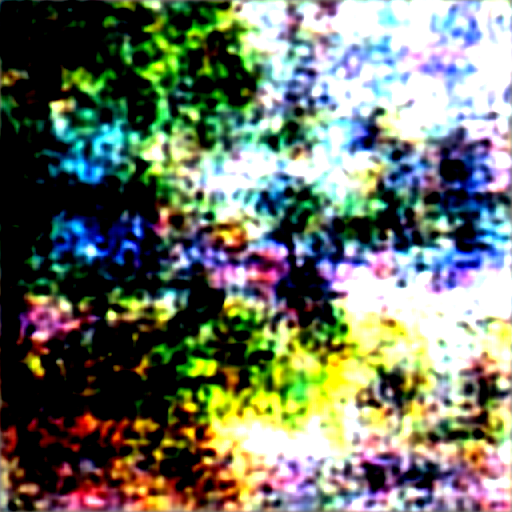

In [23]:
from torchvision.transforms.functional import to_pil_image

# Decode the latent to image using VAE
with torch.no_grad():
    image = vae.decode(latent / 0.18215).sample  # scale back the latent

# Post-process: clamp, scale, convert to PIL image
image = (image.clamp(-1, 1) + 1) / 2  # rescale from [-1, 1] to [0, 1]
image = image.cpu().squeeze(0)       # remove batch dimension → [3, 512, 512]

# Convert to PIL image
image_pil = to_pil_image(image)
from IPython.display import display
display(image_pil)

